# Step1 - 采集数据

1. 用手机拍摄视频记录你想要识别的物体。每段视频中只能包含一种物体，时长10~30秒，每个物体可以拍摄多段视频。视频尽量用4:3或1：1的长宽比，分辨率**低**越好（注意是低）。
2. 进入data/video文件夹，为每种物体新建一个文件夹，然后把相应的视频导入进去。例如我拍摄了5段关于猫的视频和3段关于狗的视频，就在data/video文件夹下新建dog、cat两个文件夹，然后把把猫的视频全部放进cat文件夹，把狗的视频全部放进dog文件夹，视频的文件名无所谓。

# Step2 - 数据处理

在这一步，我们需要把视频转成图片，然后按照60%、20%、20%的比例拆分成训练集(training set)、验证集(validation set)、和测试集(test set)。

为了节省大家时间，我事先已经写好了相关的代码(utils.py)，大家只要按照提示进行调用即可完成这一步骤。

In [17]:
import utils

#################### 以下是你可以修改的部分 ####################
fps = 8 # fps是视频的采样率，即每秒中采集多少张图片，建议设置为5~10
# 每张图片的大小，根据你原始视频的比例进行缩放，建议不要超过300x300
# 训练所需时间会和图像的像素数量成正比，建议设置得小一点，如160x120
width = 160
height = 120
#################### 以上是你可以修改的部分 ####################

utils.process_videos(fps, target_size=(width, height))

共找到4种类别: ['empty', 'paper', 'rock', 'scissor']
正在处理data\video\empty\e1.mp4
正在处理data\video\paper\p1.mp4
正在处理data\video\paper\p2.mp4
正在处理data\video\paper\p3.mp4
正在处理data\video\rock\r1.mp4
正在处理data\video\rock\r2.mp4
正在处理data\video\rock\r3.mp4
正在处理data\video\scissor\s1.mp4
正在处理data\video\scissor\s2.mp4
正在处理data\video\scissor\s3.mp4
处理完成


# Step3 - 数据增强

把一张原始图片经过拉伸、旋转、斜切、反转等操作，可以生产若干新的不同的图片，用以扩充训练集数据量，有助于提高模型的预测准确性

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

# 设置train，val，test的目录
base_dir = Path('data')
train_dir = base_dir/'train'
val_dir = base_dir/'val'
test_dir = base_dir/'test'

# 创建train和val图像生成器，它们会不断地产生出新的图片

#################### 以下是你可以修改的部分 ####################
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
#################### 以上是你可以修改的部分 ####################

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(height,width))
val_generator = train_datagen.flow_from_directory(val_dir, target_size=(height,width))

# test的时候是模拟真实环境，所以要使用原始图片，不要对图片进行任何操作
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(height,width))

C:\Users\admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 913 images belonging to 4 classes.
Found 397 images belonging to 4 classes.
Found 388 images belonging to 4 classes.


# Step4 - 搭建卷积神经网络

在这一步我们要搭建神经网络的架构。

图像识别的常见方法是通过卷积操作提取图片中的特征，然后将特征输入到神经网络中，最后神经网络输出结果。所以在这一阶段，我们要分别准备卷积和神经网络两个部分

## 4.1 - 卷积部分

### 迁移学习(transfer learning)

对图像进行卷积操作需要耗费大量计算资源，并且训练需要巨大的数据量，一般个人是搞不定这事的。

好消息是人们发现了一个有趣的现象：训练出来用于识别A物体的卷积神经网络，它的卷积部分也能够很好地被用于识别B物体。

所以我们可以把人家已经训练好的NB的卷积神经网络借来用，这就是迁移学习。


### 载入VGG16

VGG16是一个非常经典的卷积神经网络，16代表有16个层，前13层是卷积层，后3层是全连阶层。我们需要使用它的前13个卷积层，并且使用这些层的权值，用来从图像中提取特征。然后把提取后的特征输入到我们自己的神经网络中进行识别。

In [3]:
import keras as K

# load pretrained model and weights
conv_layers = K.applications.VGG16(include_top=False, input_shape=(height,width,3))
conv_layers.trainable = False
print('per-trained model has been loaded')

per-trained model has been loaded


除了VGG16以外还有很多更[先进的模型](https://keras.io/applications/)，你可以尝试更换不同的模型看看哪个效果更好。

|Model|	Size|Top-1 Accuracy|Top-5 Accuracy|Parameters|Depth|
|-|-|-|-|-|
|Xception|88 MB|0.790|0.945|22,910,480|126|
|VGG16|528 MB|0.715|0.901|138,357,544|23|
|VGG19|549 MB|0.727|0.910|143,667,240|26|
|ResNet50|99 MB|0.759|0.929|25,636,712|168|
|InceptionV3	|92 MB	|0.788	|0.944	|23,851,784	|159|
|InceptionResNetV2	|215 MB	|0.804	|0.953	|55,873,736	|572|
|MobileNet	|17 MB	|0.665	|0.871	|4,253,864	|88|
|DenseNet121	|33 MB	|0.745	|0.918	|8,062,504|	121|
|DenseNet169	|57 MB	|0.759	|0.928	|14,307,880	|169|
|DenseNet201	|80 MB	|0.770	|0.933	|20,242,984	|201|

## 4.2 - 神经网络部分

In [4]:
model = K.models.Sequential()
model.add(conv_layers)
model.add(K.layers.Flatten())
n_classes = len(utils.get_child_dir_names(base_dir/'video'))

# 以下是你可以修改的部分
model.add(K.layers.Dense(512, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(512, activation='relu'))
model.add(K.layers.Dropout(0.5))
# 以上是你可以修改的部分

model.add(K.layers.Dense(n_classes, activation='softmax')) 
print('以下是神经网络的架构：')
model.summary()

以下是神经网络的架构：
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3932672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052     

# Step5 - 训练及验证

可以尝试选择不同的优化器和优化器参数（[Keras文档](http://keras-cn.readthedocs.io/en/latest/other/optimizers/)），好的优化器能让训练结果尽快收敛并获得更高的准确率

In [5]:
opt = K.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
print('优化器设置完毕')

优化器设置完毕


下面开始训练，为了节省时间只设置了迭代20次。你可以尝试不同迭代次看看它数对最终结果的影响

In [6]:
n_epochs = 20
n_train_samples = utils.count_jpgs(train_dir)
n_val_samples = utils.count_jpgs(val_dir)
batch_size = 32
history = model.fit_generator(train_generator, steps_per_epoch=n_train_samples/batch_size, epochs=n_epochs, 
                              validation_data=val_generator, validation_steps=n_val_samples/batch_size, verbose=2)
print('训练完毕')

Epoch 1/20
 - 8s - loss: 1.3159 - acc: 0.4861 - val_loss: 0.4758 - val_acc: 0.8715
Epoch 2/20
 - 5s - loss: 0.5332 - acc: 0.7859 - val_loss: 0.2250 - val_acc: 0.9521
Epoch 3/20
 - 5s - loss: 0.3898 - acc: 0.8485 - val_loss: 0.2085 - val_acc: 0.9446
Epoch 4/20
 - 5s - loss: 0.3018 - acc: 0.9054 - val_loss: 0.2015 - val_acc: 0.9320
Epoch 5/20
 - 5s - loss: 0.2525 - acc: 0.9119 - val_loss: 0.1571 - val_acc: 0.9521
Epoch 6/20
 - 5s - loss: 0.2456 - acc: 0.9139 - val_loss: 0.1175 - val_acc: 0.9647
Epoch 7/20
 - 5s - loss: 0.2105 - acc: 0.9302 - val_loss: 0.1509 - val_acc: 0.9471
Epoch 8/20
 - 5s - loss: 0.1965 - acc: 0.9250 - val_loss: 0.1102 - val_acc: 0.9647
Epoch 9/20
 - 5s - loss: 0.2078 - acc: 0.9376 - val_loss: 0.1673 - val_acc: 0.9521
Epoch 10/20
 - 5s - loss: 0.2521 - acc: 0.9171 - val_loss: 0.1076 - val_acc: 0.9622
Epoch 11/20
 - 5s - loss: 0.2148 - acc: 0.9281 - val_loss: 0.1593 - val_acc: 0.9547
Epoch 12/20
 - 5s - loss: 0.2316 - acc: 0.9215 - val_loss: 0.1591 - val_acc: 0.9471
E

## 画图看一下训练效果

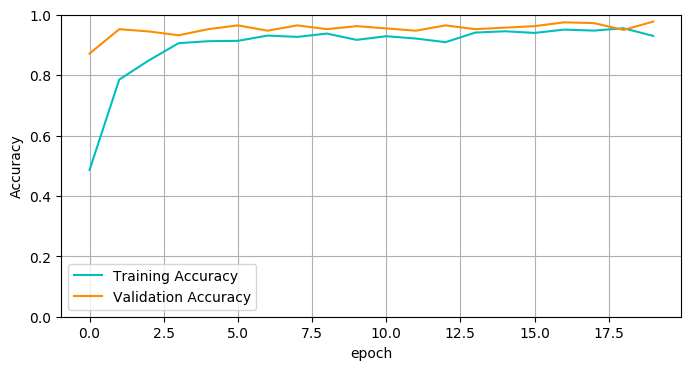

In [7]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(range(n_epochs), history.history['acc'], 'c', label='Training Accuracy', aa=True)
plt.plot(range(n_epochs), history.history['val_acc'], 'darkorange', label='Validation Accuracy', aa=True)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.grid()
plt.show()

## 怎么看训练的结果好不好
### 好的情况
总体上来看，train和val的正确率都随着迭代次数增加而上升，并且最后收敛于某一个比较高的数值。
### 两种不好的情况
1. 欠拟合（under-fitting）

train和val的正确率都比较低。
造成这种情况的原因有很多，常见的有：数据量不够大、神经网络设计得不合理、优化器选择不合理、迭代次数不够
2. 过拟合（over-fitting）

train的正确率很高，但是val正确率很低。
这种情况代表模型的泛化能力不好，它完全适应了训练集的数据（可以接近100%的正确率），但是不适用于验证集的数据。
解决方法是使用在Dense层后追加[Dropout层](https://keras-cn.readthedocs.io/en/latest/layers/core_layer/#dropout)或是在Densse层的选项中设置[regularizer](http://keras-cn.readthedocs.io/en/latest/other/regularizers/)。


# Step6 - 测试

如果上面的验证结果还不错，那恭喜你就快要成功了！
最后我们用测试集的数据来测试一下

In [9]:
n_test_samples = utils.count_jpgs(test_dir)
_, test_acc = model.evaluate_generator(test_generator, steps=n_test_samples/batch_size)
print('测试正确率：{}'.format(test_acc))

测试正确率：1.0


# Step7 - 拍张照，让程序来判断它是什么

拍一张照，上传到 daat/x 文件夹中，默认文件名是 myimage.jpg。如果你保存了其它文件名或是其它文件夹，需要修改下方代码中的路径。

## 先显示一下图片看看对不对

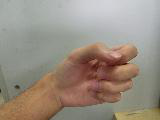

In [12]:
from PIL import Image

path = 'data/x/myimage.jpg'
img = Image.open(path)
img

## 让程序来预测试试吧

In [13]:
x = utils.preprocess(img, (width, height))
y = model.predict(x)[0]
indices = train_generator.class_indices
utils.show_pred(y, indices)

这张图片有 0.00% 的可能性是 empty
这张图片有 0.00% 的可能性是 paper
这张图片有 100.00% 的可能性是 rock
这张图片有 0.00% 的可能性是 scissor


# Optional - 用自己电脑的摄像头做实时预测

把model文件夹下载到自己电脑上，然后运行其中的predict.py即可。运行需要Python3.6和如下库：

| library | version |
| - | - |
| tensorrflow| 1.4.0 |
| keras | 2.1.3 |
| numpy | - |
| PIL | - |
| opencv | - |

In [16]:
model.save('model/mymodel.h5')
utils.save_config(indices, (width, height),'model/config.json')
print('保存成功')

保存成功
